In [1]:
import tensorflow as tf
import numpy as np
import os
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
def rounded_accuracy(y_true, y_pred):
    return tf.keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


In [5]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

4422102/4422102 [==============================] - 0s 0us/step


In [6]:
simple_encoder = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="selu"),
    tf.keras.layers.Dense(30, activation="sigmoid"),
])

In [7]:
simple_decoder = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation="selu", input_shape=[30]),
    tf.keras.layers.Dense(28 * 28, activation="sigmoid"),
    tf.keras.layers.Reshape([28, 28])
])

In [8]:
simple_ae = tf.keras.models.Sequential([simple_encoder, simple_decoder])

In [9]:
simple_ae.compile(loss="binary_crossentropy", optimizer=tf.keras.optimizers.SGD(learning_rate=1.),
                  metrics=[rounded_accuracy])

In [10]:
history = simple_ae.fit(X_train, X_train, epochs=10,
                        validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 9s 4ms/step - loss: 0.4329 - rounded_accuracy: 0.7950 - val_loss: 0.3773 - val_rounded_accuracy: 0.8492
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3612 - rounded_accuracy: 0.8668 - val_loss: 0.3514 - val_rounded_accuracy: 0.8797
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3410 - rounded_accuracy: 0.8852 - val_loss: 0.3367 - val_rounded_accuracy: 0.8912
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3288 - rounded_accuracy: 0.8954 - val_loss: 0.3263 - val_rounded_accuracy: 0.8991
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3213 - rounded_accuracy: 0.9011 - val_loss: 0.3210 - val_rounded_accuracy: 0.9032
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3176 - rounded_accuracy: 0.9038 - val_loss: 0.3179 - val_rounded_accuracy: 0.9050
Epoch 7/10
1719/1719 [==================

In [11]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [12]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

1/1 [==============================] - 0s 85ms/step


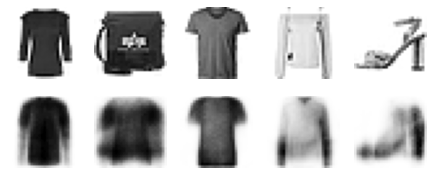

In [13]:
show_reconstructions(simple_ae)

In [14]:
from tensorflow import keras

In [15]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)
def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

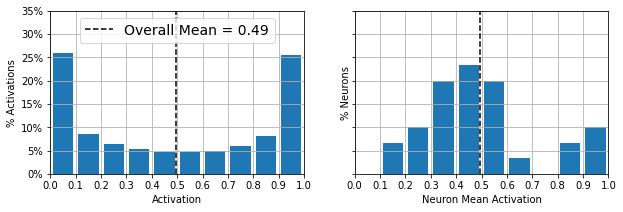

In [16]:
plot_activations_histogram(simple_encoder, height=0.35)
plt.show()

In [17]:
sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3)  # Alternatively, you could add
                                                  # activity_regularizer=keras.regularizers.l1(1e-3)
                                                  # to the previous layer.
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4298 - rounded_accuracy: 0.8160 - val_loss: 0.3866 - val_rounded_accuracy: 0.8449
Epoch 2/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3690 - rounded_accuracy: 0.8688 - val_loss: 0.3649 - val_rounded_accuracy: 0.8763
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3535 - rounded_accuracy: 0.8806 - val_loss: 0.3508 - val_rounded_accuracy: 0.8862
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3440 - rounded_accuracy: 0.8871 - val_loss: 0.3428 - val_rounded_accuracy: 0.8885
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3382 - rounded_accuracy: 0.8910 - val_loss: 0.3377 - val_rounded_accuracy: 0.8923
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3334 - rounded_accuracy: 0.8948 - val_loss: 0.3328 - val_rounded_accuracy: 0.8973
Epoch 7/10
1719/1719 [==================

1/1 [==============================] - 0s 70ms/step


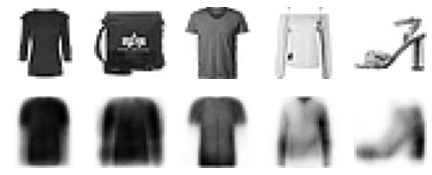

In [18]:
show_reconstructions(sparse_l1_ae)

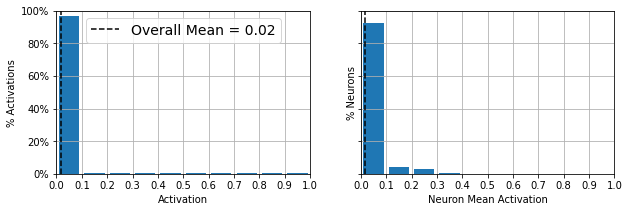

In [19]:
plot_activations_histogram(sparse_l1_encoder, height=1.)
plt.show()

(0.0, 1.0, 0.0, 0.95)

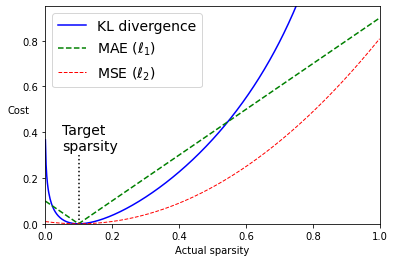

In [23]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

In [21]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

In [22]:
kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 10s 5ms/step - loss: 0.4148 - rounded_accuracy: 0.8120 - val_loss: 0.3699 - val_rounded_accuracy: 0.8605
Epoch 2/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3509 - rounded_accuracy: 0.8789 - val_loss: 0.3418 - val_rounded_accuracy: 0.8870
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3322 - rounded_accuracy: 0.8935 - val_loss: 0.3277 - val_rounded_accuracy: 0.8993
Epoch 4/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3211 - rounded_accuracy: 0.9032 - val_loss: 0.3202 - val_rounded_accuracy: 0.9056
Epoch 5/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3159 - rounded_accuracy: 0.9074 - val_loss: 0.3161 - val_rounded_accuracy: 0.9088
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3126 - rounded_accuracy: 0.9101 - val_loss: 0.3132 - val_rounded_accuracy: 0.9111
Epoch 7/10
1719/1719 [=================

1/1 [==============================] - 0s 85ms/step


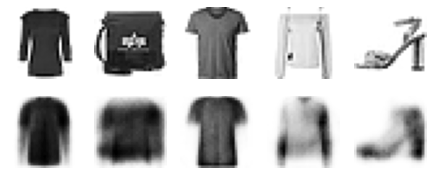

In [24]:
show_reconstructions(sparse_kl_ae)

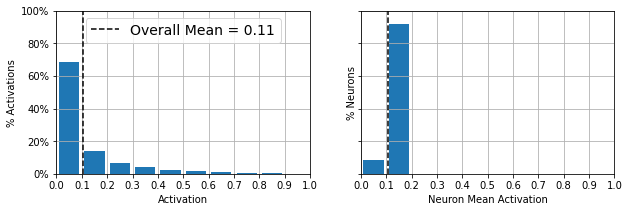

In [25]:
plot_activations_histogram(sparse_kl_encoder)
plt.show()